In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image

In [ ]:
# Step 1: Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 224

In [ ]:
 Step 2: Data Preparation with Augmentation
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/train", transform=data_transforms)
valid_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/valid", transform=data_transforms)
test_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/test", transform=data_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Step 3: Model Initialization
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, len(train_data.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:08<00:00, 43.0MB/s]


In [ ]:
# Step 4: Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Step 5: Training Loop
train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_losses.append(valid_loss / len(valid_loader))
    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

Epoch [1/20], Train Loss: 1.3139, Valid Loss: 1.1512
Epoch [2/20], Train Loss: 1.1488, Valid Loss: 1.1828
Epoch [3/20], Train Loss: 1.0869, Valid Loss: 1.0326
Epoch [4/20], Train Loss: 1.1249, Valid Loss: 1.1034
Epoch [5/20], Train Loss: 1.0882, Valid Loss: 1.1224
Epoch [6/20], Train Loss: 1.0645, Valid Loss: 1.0639
Epoch [7/20], Train Loss: 0.9772, Valid Loss: 0.8803
Epoch [8/20], Train Loss: 0.8436, Valid Loss: 0.7812
Epoch [9/20], Train Loss: 0.8495, Valid Loss: 0.9826
Epoch [10/20], Train Loss: 0.7610, Valid Loss: 0.7497
Epoch [11/20], Train Loss: 0.6784, Valid Loss: 0.6988
Epoch [12/20], Train Loss: 0.6611, Valid Loss: 0.6628
Epoch [13/20], Train Loss: 0.6426, Valid Loss: 0.7501
Epoch [14/20], Train Loss: 0.6311, Valid Loss: 0.6857
Epoch [15/20], Train Loss: 0.6130, Valid Loss: 0.6297
Epoch [16/20], Train Loss: 0.5702, Valid Loss: 0.5634
Epoch [17/20], Train Loss: 0.5490, Valid Loss: 0.5214
Epoch [18/20], Train Loss: 0.5307, Valid Loss: 0.6493
Epoch [19/20], Train Loss: 0.5583, Va

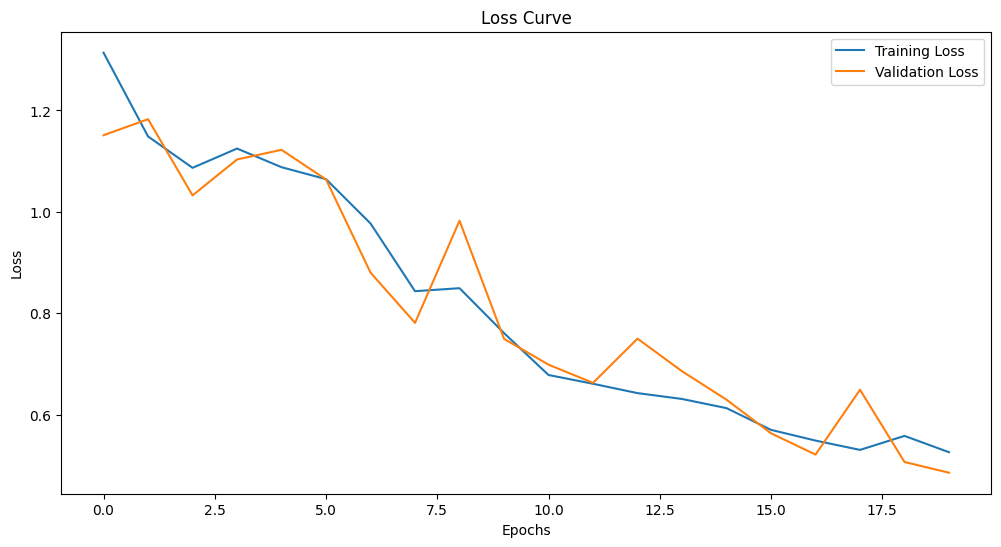

In [ ]:
# Step 6: Plotting Loss and Learning Rate
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 7: Saving the Model
model_save_path = "/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/model_vit_meat.pth"
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {model_save_path}')

Model saved at /content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/model_vit_meat.pth


In [ ]:
# Step 8: Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

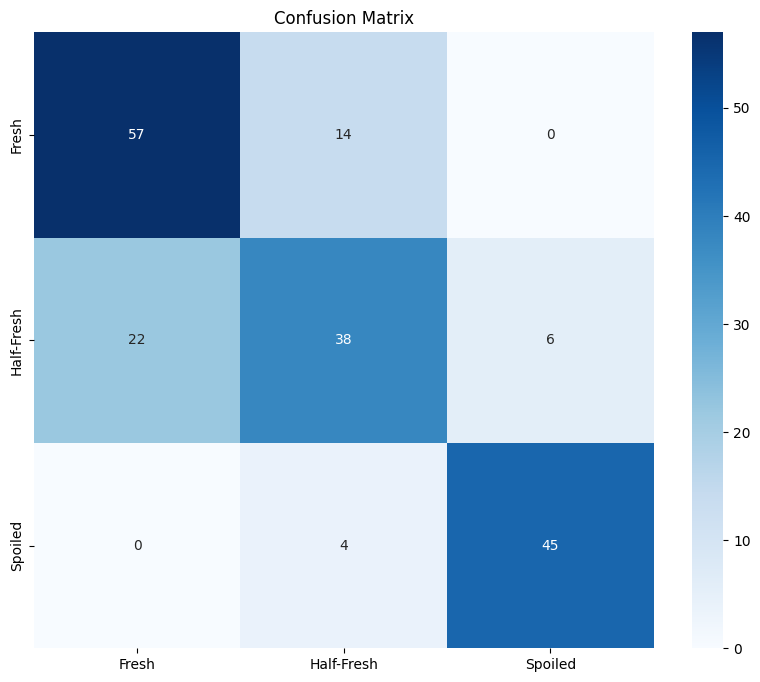

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

              precision    recall  f1-score   support

       Fresh       0.72      0.80      0.76        71
  Half-Fresh       0.68      0.58      0.62        66
     Spoiled       0.88      0.92      0.90        49

    accuracy                           0.75       186
   macro avg       0.76      0.77      0.76       186
weighted avg       0.75      0.75      0.75       186



**second try improved model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from PIL import Image
import os
from collections import Counter

In [ ]:
# Step 1: Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 3e-4  # Reduced for fine-tuning
IMG_SIZE = 224
PATIENCE = 5  # For early stopping

In [ ]:
# Step 2: Data Preparation with Improved Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomErasing(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/train", transform=train_transforms)
valid_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/valid", transform=test_transforms)
test_data = datasets.ImageFolder("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Compute class weights for imbalanced dataset
class_counts = Counter(train_data.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]).to(device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Step 3: Model Initialization with Partial Fine-Tuning
model = vit_b_16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last transformer block
for param in model.encoder.layers[-1].parameters():
    param.requires_grad = True

model.heads.head = nn.Linear(model.heads.head.in_features, len(train_data.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Step 4: Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW([
    {'params': model.encoder.layers[-1].parameters(), 'lr': LEARNING_RATE},
    {'params': model.heads.parameters(), 'lr': LEARNING_RATE * 10}
], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
# Step 5: Training Loop with Early Stopping and Visualization
train_losses = []
valid_losses = []
valid_accuracies = []
best_acc = 0.0
patience_counter = 0
PATIENCE = 5  # Setting patience for early stopping

scaler = torch.amp.GradScaler(device='cuda')  # Mixed Precision Training (Updated)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_acc = 100 * correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    # Save best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/best_model_vit_meat.pth")
        print("Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break

    # Visualization
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(valid_losses, label='Validation Loss')
        plt.title(f'Loss Curve - Epoch {epoch + 1}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(valid_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy Curve - Epoch {epoch + 1}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.show()


In [ ]:
# Step 6: Evaluation with Enhanced Metrics
model.load_state_dict(torch.load("/content/drive/MyDrive/MEAT FRESHNESS.v1i.folder/best_model_vit_meat.pth"))
model.eval()
y_true = []
y_pred = []
y_scores = []
misclassified_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probabilities.cpu().numpy())

        # Collect misclassified images
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append({
                    'image': images[i].cpu(),
                    'true_label': train_data.classes[labels[i]],
                    'predicted_label': train_data.classes[predicted[i]]
                })

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Multi-Class ROC (One-vs-Rest)
plt.figure()
for i in range(len(train_data.classes)):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{train_data.classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

In [ ]:
# Top-2 Accuracy
top2_correct = 0
total = len(y_true)
for true_label, scores in zip(y_true, y_scores):
    top2_preds = np.argsort(scores)[-2:]
    if true_label in top2_preds:
        top2_correct += 1
print(f"Top-2 Accuracy: {100 * top2_correct / total:.2f}%")